In [1]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import torch
import math
import timm

import transforms.eft as Eft
import datasets.radioml_dataset as RadiomlDT
from datasets.transformed_dataset import TransformedDataset
from utils import plot_confusion_matrix
from models.radio_rec_model import RadioRecNetwork
from models.resnet import create_resnet

In [2]:
print(torch.cuda.is_available())

True


In [3]:
root = "/home/zwlin/data/radioml"
radioml2018 = RadiomlDT.RadioML2018(root, min_db = 0, max_db=26)
num_classes = len(radioml2018.class_list)
label_list = radioml2018.class_list

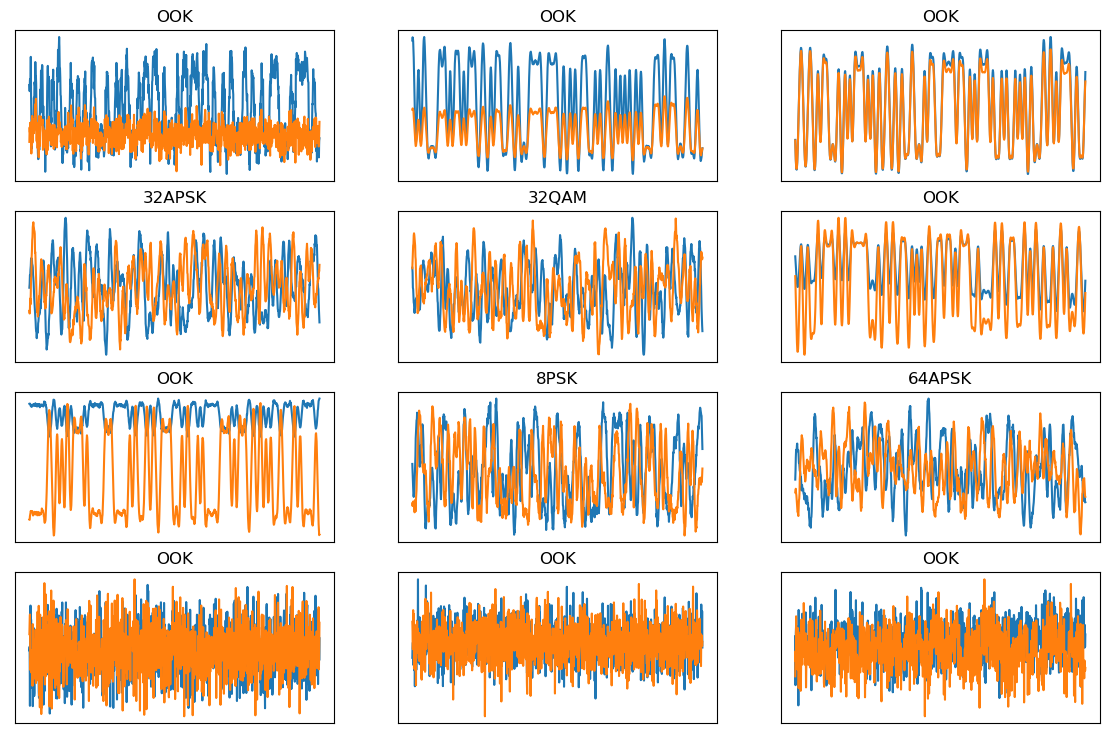

In [4]:
# Repeat but plot andom sampling of the data
from datasets.visualize import IQVisualizer

example_dataloader = DataLoader(
    dataset=radioml2018,
    batch_size=12,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
visualizer = IQVisualizer(
    data_loader = example_dataloader,
    visualize_target_transform = lambda target: [label_list[int(index)] for index in target]
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break

In [5]:
interleave_to_2d = Eft.InterleaveTo2D()
ds = TransformedDataset(radioml2018, transform = interleave_to_2d)

In [6]:
num_total = len(ds)
num_train = math.floor(0.8 * num_total)
num_val = math.floor(0.1 * num_total)
num_test = num_total - num_train - num_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(ds, [num_train, num_val, num_test],
                                                                         generator = torch.Generator().manual_seed(42))
idx = np.random.randint(len(train_dataset))
data, label = train_dataset[idx]
channels = data.shape[0]
print("Dataset length: {}".format(len(ds)))
print("Data shape: {}".format(data.shape))
print(f"Channels: {channels}")
print("Label Index: {}".format(label))
print("Label Class: {}".format(label_list[label]))

Dataset length: 200704
Data shape: (2, 1024)
Channels: 2
Label Index: 0
Label Class: OOK


In [7]:
# ----
# ### Format Dataset for Training
# Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=2048,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=2048,
    num_workers=10,
    shuffle=False,
    drop_last=False,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=2048,
    num_workers=10,
    shuffle=False,
    drop_last=False,
)

In [8]:
model = create_resnet(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
model

ResNet(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
# Training Config
learning_rate=0.002
epochs = 50

radiorec_model = RadioRecNetwork(model, learning_rate = learning_rate)

In [11]:
# ----
# ### Train the Model
# To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.
import os
checkpoint_dir=f'exp/radioml2018-iq-all-{rediorec_model.learning_rate}-v3/checkpoints'
if not os.path.exists(checkpoint_dir):
    print(f'mkdir: {checkpoint_dir}')
    os.makedirs(checkpoint_dir)

mkdir: exp/radioml2018-iq-all-0.002-v3/checkpoints


In [12]:
# Setup checkpoint callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename='{epoch}-{val_loss:.2f}',
    save_top_k=3,
    save_last=True,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

In [13]:
# Create and fit trainer

trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, devices=1, accelerator="gpu"
)

trainer.fit(radiorec_model, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | mdl  | ResNet | 3.9 M 
--------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.446    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 78: 'val_loss' reached 0.89859 (best 0.89859), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=0-val_loss=0.90.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 156: 'val_loss' reached 0.58806 (best 0.58806), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=1-val_loss=0.59.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 234: 'val_loss' reached 0.47809 (best 0.47809), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=2-val_loss=0.48.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 312: 'val_loss' reached 0.57854 (best 0.47809), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=3-val_loss=0.58.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 390: 'val_loss' reached 0.42779 (best 0.42779), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=4-val_loss=0.43.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 468: 'val_loss' reached 0.51277 (best 0.42779), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=5-val_loss=0.51.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 546: 'val_loss' reached 0.31570 (best 0.31570), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=6-val_loss=0.32.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 624: 'val_loss' reached 0.28137 (best 0.28137), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=7-val_loss=0.28.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 702: 'val_loss' reached 0.30252 (best 0.28137), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=8-val_loss=0.30.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 780: 'val_loss' reached 0.27318 (best 0.27318), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=9-val_loss=0.27.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 858: 'val_loss' reached 0.23026 (best 0.23026), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=10-val_loss=0.23.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 936: 'val_loss' reached 0.24228 (best 0.23026), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=11-val_loss=0.24.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1014: 'val_loss' reached 0.20993 (best 0.20993), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=12-val_loss=0.21.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1092: 'val_loss' reached 0.23593 (best 0.20993), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=13-val_loss=0.24.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1170: 'val_loss' reached 0.18911 (best 0.18911), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=14-val_loss=0.19.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1248: 'val_loss' reached 0.21854 (best 0.18911), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=15-val_loss=0.22.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1326: 'val_loss' reached 0.18453 (best 0.18453), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=16-val_loss=0.18.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1404: 'val_loss' reached 0.16819 (best 0.16819), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=17-val_loss=0.17.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1482: 'val_loss' reached 0.15840 (best 0.15840), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=18-val_loss=0.16.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 1560: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 1638: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 1716: 'val_loss' reached 0.16145 (best 0.15840), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=21-val_loss=0.16.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 1794: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 1872: 'val_loss' reached 0.16066 (best 0.15840), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=23-val_loss=0.16.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 1950: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 2028: 'val_loss' reached 0.12668 (best 0.12668), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=25-val_loss=0.13.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 2106: 'val_loss' reached 0.12600 (best 0.12600), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=26-val_loss=0.13.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 2184: 'val_loss' reached 0.12793 (best 0.12600), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=27-val_loss=0.13.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 2262: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 2340: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 2418: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 2496: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 2574: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 2652: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 2730: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 2808: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 2886: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 2964: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 3042: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 3120: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 3198: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 3276: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 3354: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 3432: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 3510: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 3588: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 3666: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 3744: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 3822: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 3900: 'val_loss' was not in top 3


In [14]:
checkpoint_callback.best_model_path

'/home/zwlin/projects/radiorec/src/RadioRec/exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=26-val_loss=0.13.ckpt'

In [15]:
# After the model is trained, the checkpoint's weights are loaded into the model and the model is put into evaluation mode. The validation set is looped through, inferring results for each example and saving the predictions and the labels. Finally, the labels and predictions are passed into our confusion matrix plotting function to view the results and also passed into the `sklearn.metrics.classification_report` method to print metrics of interest.
# checkpoint_filename = checkpoint_callback.best_model_path
checkpoint_filename = 'exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=26-val_loss=0.13.ckpt'

# Load best checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(
    checkpoint_filename, map_location=lambda storage, loc: storage
)

model = create_resnet(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
test_model = RadioRecNetwork(model, learning_rate = learning_rate)
test_model.load_state_dict(checkpoint["state_dict"])
test_model = test_model.to(device=device).eval()

In [16]:
# ### Evaluate the val set

# Infer results over validation set
num_val_examples = len(val_dataset)
y_raw_preds = np.empty((num_val_examples, num_classes))
y_preds = np.zeros((num_val_examples,))
y_true = np.zeros((num_val_examples,))

for i in tqdm(range(0, num_val_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = val_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

100%|████████████████████████████████████| 20070/20070 [00:48<00:00, 412.80it/s]


Val set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10521
         1.0       0.99      0.99      0.99       409
         2.0       1.00      0.99      0.99       444
         3.0       1.00      1.00      1.00       448
         4.0       1.00      1.00      1.00       438
         5.0       0.99      0.99      0.99       397
         6.0       0.88      0.88      0.88       418
         7.0       0.88      0.88      0.88       433
         8.0       1.00      1.00      1.00       428
         9.0       0.99      0.99      0.99       435
        10.0       0.88      0.91      0.90       414
        11.0       0.90      0.86      0.88       399
        12.0       0.99      0.99      0.99       438
        13.0       0.85      0.87      0.86       407
        14.0       0.58      0.56      0.57       418
        15.0       0.63      0.64      0.63       389
        16.0       0.56      0.56      0.56       

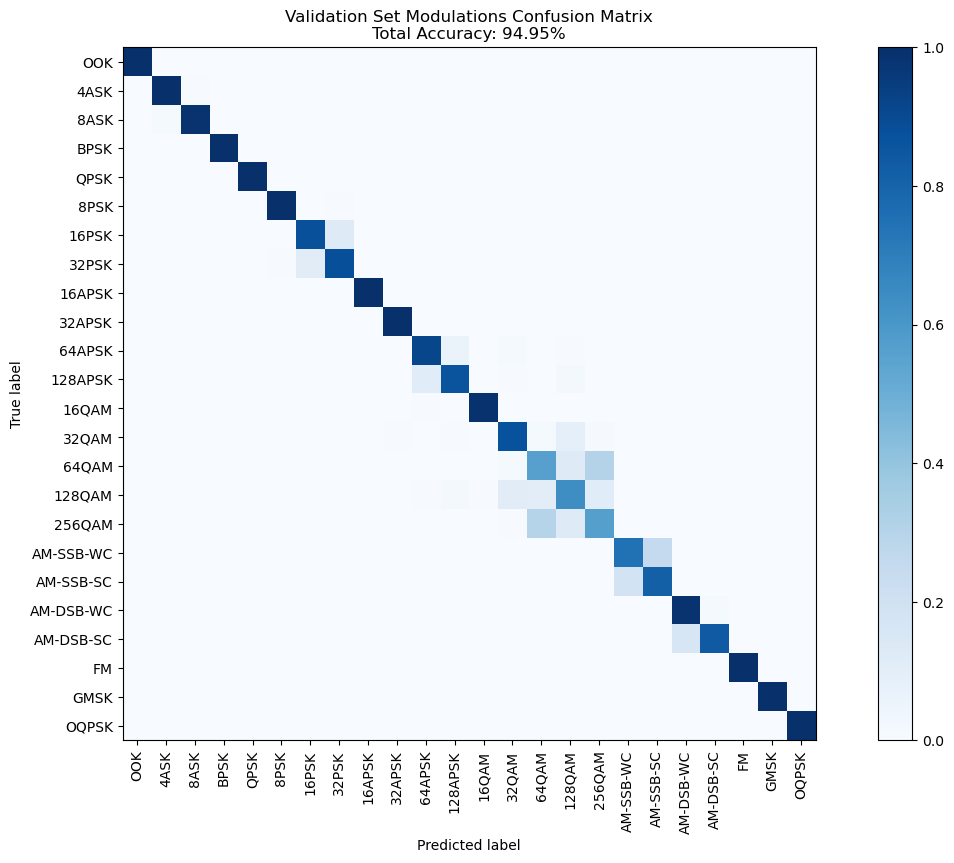

In [17]:
acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = label_list,
    normalize = True,
    title="Validation Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/val_result.png")

print("Val set classification report:")
print(classification_report(y_true, y_preds))

100%|████████████████████████████████████| 20071/20071 [00:52<00:00, 381.70it/s]


Test set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10654
         1.0       0.99      1.00      0.99       411
         2.0       1.00      0.98      0.99       392
         3.0       1.00      1.00      1.00       426
         4.0       1.00      1.00      1.00       406
         5.0       1.00      1.00      1.00       419
         6.0       0.88      0.90      0.89       408
         7.0       0.90      0.88      0.89       400
         8.0       1.00      1.00      1.00       403
         9.0       1.00      1.00      1.00       420
        10.0       0.92      0.91      0.91       440
        11.0       0.87      0.88      0.88       396
        12.0       0.99      1.00      0.99       396
        13.0       0.82      0.87      0.84       385
        14.0       0.57      0.55      0.56       418
        15.0       0.60      0.62      0.61       420
        16.0       0.55      0.51      0.53      

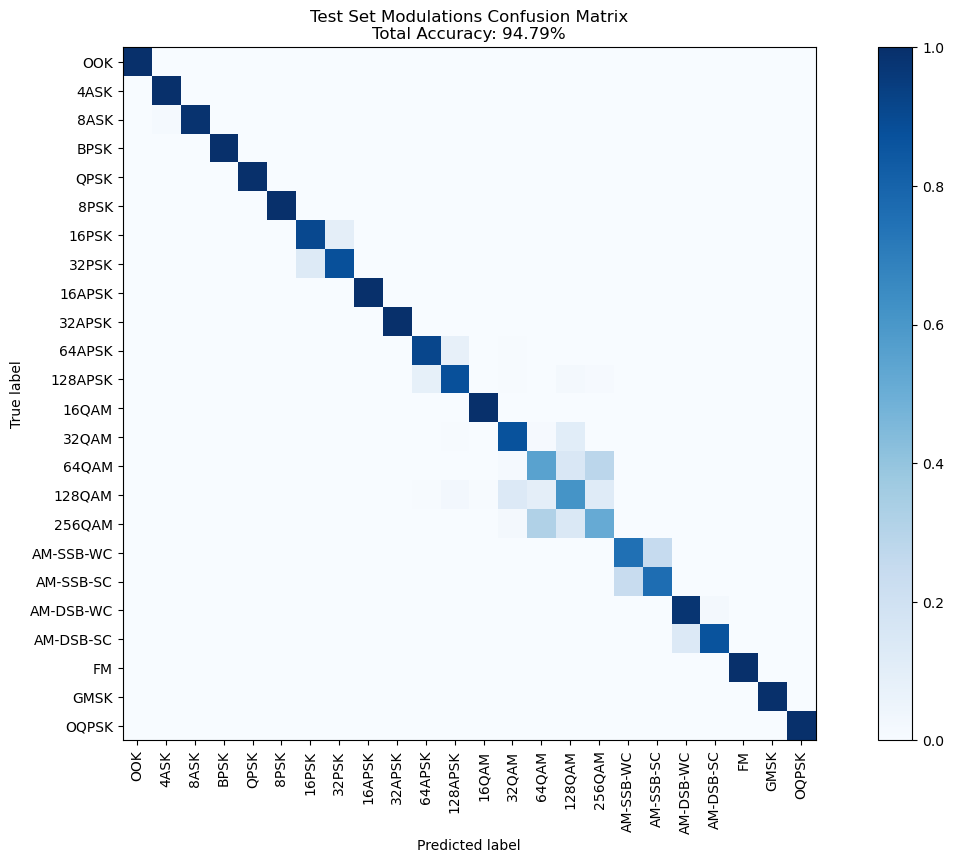

In [18]:
# ----
# ### Evaluate the test set

# Infer results over validation set
num_test_examples = len(test_dataset)
y_raw_preds = np.empty((num_test_examples, num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = test_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = label_list,
    normalize = True,
    title="Test Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/test_result.png")

print("Test set classification report:")
print(classification_report(y_true, y_preds))